In [1]:
import numpy as np
import pandas as pd

In [2]:
abundance = pd.read_csv("../../results/data/prepared/processed_abundance.csv")
clinical = pd.read_csv("../../results/data/prepared/clinical.csv")
groups = pd.read_csv("../../results/data/prepared/groups.csv")

abundance = abundance.pivot(index="sample", columns="glycan", values="value")
abundance = pd.DataFrame(np.log2(abundance.values), columns=abundance.columns, index=abundance.index)
clinical = clinical.drop(["sex", "age"], axis=1)
clinical = clinical.set_index("sample")
groups = groups.set_index("sample")
data = pd.merge(abundance, clinical, left_index=True, right_index=True, how="inner")
data = pd.merge(data, groups, left_index=True, right_index=True, how="inner")
data = data[data["group"] != "QC"]
# data.loc[data["group"] == "M", "group"] = "H"
data["group"] = data["group"] == "C"

In [3]:
clinical_features = clinical.columns.tolist()
glycan_features = abundance.columns.tolist()

In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=128, random_state=42, stratify=data["group"], shuffle=True)

In [5]:
X_train = train_data.drop("group", axis=1)
y_train = train_data["group"]
X_test = test_data.drop("group", axis=1)
y_test = test_data["group"]

In [6]:
X_train.head()

,H3N3,H3N3F1,H3N4,H3N4F1,H3N5,H3N5F1,H4N2,H4N3,H4N3F1,H4N3F1S1,...,AST,ALT,GGT,ALB,TBIL,TP,AFP,HCV,CEA,CA199
sample,,,,,,,,,,,,,,,,,,,,,
S123,12.126891,11.797564,11.188617,15.992716,12.049130,13.325982,9.530232,12.296704,11.684790,8.530232,...,0,11,0,42.82,16.9,67.7,0.00,0.0,0.00,0.00
S549,11.953019,11.901987,11.459164,15.417039,11.663211,13.153128,9.874411,12.007467,11.942351,12.653387,...,25,23,424,34.38,44.9,59.9,0.00,0.0,0.00,0.00
S626,11.829985,11.687135,10.294023,15.006981,11.386611,13.257160,10.294023,11.859289,11.422261,12.404590,...,21,15,21,49.80,11.4,75.8,3.47,0.0,1.99,14.96
S494,10.952821,11.795057,12.204758,16.395196,13.424326,14.955106,9.244854,11.210018,11.668416,12.166124,...,42,29,63,29.70,32.5,62.3,21.24,0.0,0.00,21.63
S377,10.415901,12.225450,10.415901,15.459247,11.415901,13.515596,10.415901,12.414026,11.720350,12.469854,...,14,9,0,42.60,12.7,74.7,2.91,0.0,0.00,0.00


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
svm = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))

rf_accs = cross_val_score(rf, X_train, y_train, cv=10, scoring="accuracy")
rf_aucs = cross_val_score(rf, X_train, y_train, cv=10, scoring="roc_auc")
lr_accs = cross_val_score(lr, X_train, y_train, cv=10, scoring="accuracy")
lr_aucs = cross_val_score(lr, X_train, y_train, cv=10, scoring="roc_auc")
svm_accs = cross_val_score(svm, X_train, y_train, cv=10, scoring="accuracy")
svm_aucs = cross_val_score(svm, X_train, y_train, cv=10, scoring="roc_auc")

print(f"Random Forest ACC: {rf_accs.mean():.2f} +/- {rf_accs.std():.2f}")
print(f"Random Forest AUC: {rf_aucs.mean():.2f} +/- {rf_aucs.std():.2f}")
print(f"Logistic Regression ACC: {lr_accs.mean():.2f} +/- {lr_accs.std():.2f}")
print(f"Logistic Regression AUC: {lr_aucs.mean():.2f} +/- {lr_aucs.std():.2f}")
print(f"SVM ACC: {svm_accs.mean():.2f} +/- {svm_accs.std():.2f}")
print(f"SVM AUC: {svm_aucs.mean():.2f} +/- {svm_aucs.std():.2f}")

Random Forest ACC: 0.85 +/- 0.04
Random Forest AUC: 0.90 +/- 0.04
Logistic Regression ACC: 0.78 +/- 0.05
Logistic Regression AUC: 0.85 +/- 0.07
SVM ACC: 0.81 +/- 0.05
SVM AUC: 0.89 +/- 0.05


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels


class FusionModel(BaseEstimator, TransformerMixin, ClassifierMixin):

    clinical_features = clinical.columns.tolist()
    glycan_features = abundance.columns.tolist()

    def __init__(self, clinical_model, glycan_model):
        self.clinical_model = clinical_model
        self.glycan_model = glycan_model
        self.final_model = LogisticRegression(random_state=42)

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.clinical_model.fit(X[self.clinical_features], y)
        self.glycan_model.fit(X[self.glycan_features], y)
        proba_clinical = self.clinical_model.predict_proba(X[self.clinical_features])[:, 1]
        proba_glycan = self.glycan_model.predict_proba(X[self.glycan_features])[:, 1]
        X_fusion = np.vstack([proba_clinical, proba_glycan]).T
        self.final_model.fit(X_fusion, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        proba_clinical = self.clinical_model.predict_proba(X[self.clinical_features])[:, 1]
        proba_glycan = self.glycan_model.predict_proba(X[self.glycan_features])[:, 1]
        X_fusion = np.vstack([proba_clinical, proba_glycan]).T
        return self.final_model.predict(X_fusion)
    
    def predict_proba(self, X):
        proba_clinical = self.clinical_model.predict_proba(X[self.clinical_features])[:, 1]
        proba_glycan = self.glycan_model.predict_proba(X[self.glycan_features])[:, 1]
        X_fusion = np.vstack([proba_clinical, proba_glycan]).T
        return self.final_model.predict_proba(X_fusion)

In [9]:
fusion_model = FusionModel(
    clinical_model=RandomForestClassifier(n_estimators=100, random_state=42), 
    glycan_model=make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
)

fusion_accs = cross_val_score(fusion_model, X_train, y_train, cv=10, scoring="accuracy")
fusion_aucs = cross_val_score(fusion_model, X_train, y_train, cv=10, scoring="roc_auc")

print(f"Fusion ACC: {fusion_accs.mean():.2f} +/- {fusion_accs.std():.2f}")
print(f"Fusion AUC: {fusion_aucs.mean():.2f} +/- {fusion_aucs.std():.2f}")

Fusion ACC: 0.89 +/- 0.04
Fusion AUC: 0.94 +/- 0.03


In [10]:
from sklearn.metrics import classification_report

fusion_model.fit(X_train, y_train)
y_pred = fusion_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.89      0.91        71
        True       0.87      0.91      0.89        57

    accuracy                           0.90       128
   macro avg       0.90      0.90      0.90       128
weighted avg       0.90      0.90      0.90       128



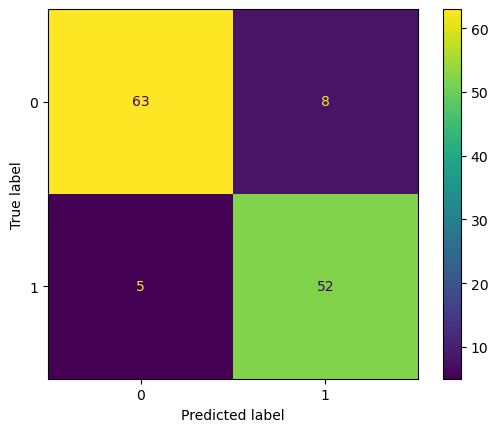

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()